In [10]:
#%pip install pandas matplotlib seaborn plotly scikit-learn seaborn missingno

In [63]:
from time import sleep

import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.model_selection import train_test_split
import pandas as pd
from IPython.display import display, HTML
import missingno as mn
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

sns.set()

In [64]:
#Интерактивные графики в отдельном окне
%matplotlib tk

In [65]:
%matplotlib inline

In [66]:
RANDOM_SEED = 42


Загрузка данных

In [67]:
df = pd.read_csv("autos.csv")

### Проверим типы данных

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

### Проверим  дубликаты

In [69]:
if df.duplicated().sum():
    df = df.drop_duplicates()
    df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 354365 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354365 non-null  object
 1   Price              354365 non-null  int64 
 2   VehicleType        316875 non-null  object
 3   RegistrationYear   354365 non-null  int64 
 4   Gearbox            334532 non-null  object
 5   Power              354365 non-null  int64 
 6   Model              334660 non-null  object
 7   Kilometer          354365 non-null  int64 
 8   RegistrationMonth  354365 non-null  int64 
 9   FuelType           321470 non-null  object
 10  Brand              354365 non-null  object
 11  Repaired           283211 non-null  object
 12  DateCreated        354365 non-null  object
 13  NumberOfPictures   354365 non-null  int64 
 14  PostalCode         354365 non-null  int64 
 15  LastSeen           354365 non-null  object
dtypes: int64(7), object(9)
me

In [70]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


* Преобразование данных

Начнем с даты.

In [71]:
df["DateCrawled"] = pd.to_datetime(df.DateCrawled)
df["DateCreated"] = pd.to_datetime(df.DateCreated)
df["LastSeen"] = pd.to_datetime(df.LastSeen)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 354365 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354365 non-null  datetime64[ns]
 1   Price              354365 non-null  int64         
 2   VehicleType        316875 non-null  object        
 3   RegistrationYear   354365 non-null  int64         
 4   Gearbox            334532 non-null  object        
 5   Power              354365 non-null  int64         
 6   Model              334660 non-null  object        
 7   Kilometer          354365 non-null  int64         
 8   RegistrationMonth  354365 non-null  int64         
 9   FuelType           321470 non-null  object        
 10  Brand              354365 non-null  object        
 11  Repaired           283211 non-null  object        
 12  DateCreated        354365 non-null  datetime64[ns]
 13  NumberOfPictures   354365 non-null  int64        

In [30]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
DateCrawled,354365,2016-03-21 12:58:09.520460544,2016-03-05 14:06:22,2016-03-13 11:52:33,2016-03-21 17:50:55,2016-03-29 14:37:20,2016-04-07 14:36:58,NaN
Price,354365.0,4416.67983,0.0,1050.0,2700.0,6400.0,20000.0,4514.176349
RegistrationYear,354365.0,2004.234481,1000.0,1999.0,2003.0,2008.0,9999.0,90.228466
Power,354365.0,110.093816,0.0,69.0,105.0,143.0,20000.0,189.85133
Kilometer,354365.0,128211.363989,5000.0,125000.0,150000.0,150000.0,150000.0,37905.083858
RegistrationMonth,354365.0,5.71465,0.0,3.0,6.0,9.0,12.0,3.726432
DateCreated,354365,2016-03-20 19:12:06.583042560,2014-03-10 00:00:00,2016-03-13 00:00:00,2016-03-21 00:00:00,2016-03-29 00:00:00,2016-04-07 00:00:00,NaN
NumberOfPictures,354365.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PostalCode,354365.0,50508.5038,1067.0,30165.0,49413.0,71083.0,99998.0,25783.100078
LastSeen,354365,2016-03-29 23:51:06.766184960,2016-03-05 14:15:08,2016-03-23 02:50:03,2016-04-03 15:15:52,2016-04-06 10:15:19,2016-04-07 14:58:51,NaN


Видим, что есть 
* нулевая Price
* нереальный RegistrationYear
* огромная Power

Отфильтруем эти данные

<Axes: xlabel='Power', ylabel='Count'>

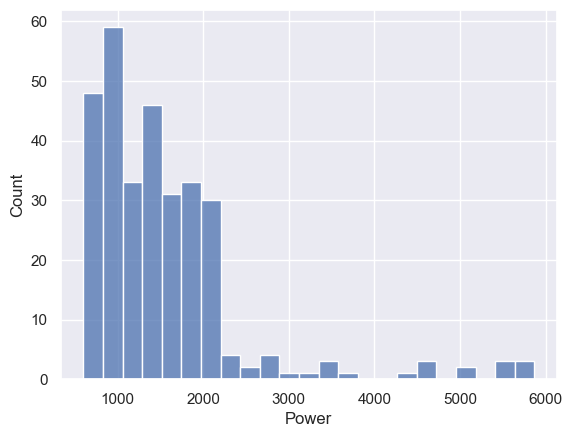

In [31]:
sns.histplot(df.Power.loc[(df.Power > 600) & (df.Power < 6000)])

Возможно пользователь ошибся и добавил лишние нули. Попробуем восстановить мощность по модели

Найдем среднее значение мощности для выбранных моделей

In [72]:
huge_power_models = df.loc[df.Power > 600].Model.unique().tolist()
median_power = {}
for model in huge_power_models:
    median = df["Power"].loc[df.Model == model].median()
    try:
        median_power[model] = round(median)
    except ValueError:
        print(model, "can't convert to int", median)


nan can't convert to int nan


In [73]:
# Удалим other
del median_power["other"]

In [74]:
# сохраним датасет
original_df = df.copy()


In [35]:
df = original_df.copy()

In [245]:
original_df.describe().T

,count,mean,min,25%,50%,75%,max,std
DateCrawled,354365,2016-03-21 12:58:09.520460544,2016-03-05 14:06:22,2016-03-13 11:52:33,2016-03-21 17:50:55,2016-03-29 14:37:20,2016-04-07 14:36:58,NaN
Price,354365.0,4416.67983,0.0,1050.0,2700.0,6400.0,20000.0,4514.176349
RegistrationYear,354365.0,2004.234481,1000.0,1999.0,2003.0,2008.0,9999.0,90.228466
Power,354365.0,110.093816,0.0,69.0,105.0,143.0,20000.0,189.85133
Kilometer,354365.0,128211.363989,5000.0,125000.0,150000.0,150000.0,150000.0,37905.083858
RegistrationMonth,354365.0,5.71465,0.0,3.0,6.0,9.0,12.0,3.726432
DateCreated,354365,2016-03-20 19:12:06.583042560,2014-03-10 00:00:00,2016-03-13 00:00:00,2016-03-21 00:00:00,2016-03-29 00:00:00,2016-04-07 00:00:00,NaN
NumberOfPictures,354365.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PostalCode,354365.0,50508.5038,1067.0,30165.0,49413.0,71083.0,99998.0,25783.100078
LastSeen,354365,2016-03-29 23:51:06.766184960,2016-03-05 14:15:08,2016-03-23 02:50:03,2016-04-03 15:15:52,2016-04-06 10:15:19,2016-04-07 14:58:51,NaN


In [75]:
# Восстановим мощности
df["Power"].update(df.loc[df.Power > 600]["Model"].map(median_power))


In [37]:
df.loc[df.Power > 600]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
3746,2016-03-21 14:48:31,0,NaN,2017,manual,750,NaN,150000,8,petrol,smart,no,2016-03-21,0,49356,2016-03-24 03:44:59
7720,2016-04-02 11:48:54,1500,small,2000,manual,1400,NaN,150000,0,petrol,honda,NaN,2016-04-02,0,21509,2016-04-04 09:15:26
11039,2016-03-25 19:55:32,0,sedan,1998,manual,10317,other,150000,8,petrol,fiat,no,2016-03-25,0,57520,2016-04-01 19:16:33
21609,2016-03-29 17:53:17,200,small,2000,manual,1200,NaN,125000,4,petrol,lancia,NaN,2016-03-29,0,10585,2016-04-06 03:45:24
23173,2016-03-19 22:51:21,400,NaN,2015,auto,610,other,5000,1,NaN,audi,NaN,2016-03-19,0,70178,2016-03-20 02:42:18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319576,2016-03-17 20:56:34,2300,sedan,1992,NaN,1922,NaN,150000,4,petrol,bmw,no,2016-03-17,0,45896,2016-03-17 21:43:16
320442,2016-03-22 08:54:07,3400,small,2007,NaN,732,NaN,125000,12,petrol,citroen,no,2016-03-22,0,3159,2016-04-05 21:15:48
321246,2016-03-22 18:31:32,650,suv,1996,manual,2389,NaN,150000,11,petrol,nissan,no,2016-03-22,0,35579,2016-03-29 01:16:32
348830,2016-03-22 00:38:15,1,NaN,1000,NaN,1000,NaN,150000,0,NaN,sonstige_autos,NaN,2016-03-21,0,41472,2016-04-05 14:18:01


Для этих авто не указаны ни корректная мощность, ни модель. Удаляем их

In [76]:
df.drop(df[df.Power > 600].index, inplace=True)

In [39]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
DateCrawled,354292,2016-03-21 12:57:41.131425792,2016-03-05 14:06:22,2016-03-13 11:52:25.249999872,2016-03-21 17:50:53.500000,2016-03-29 14:37:19,2016-04-07 14:36:58,NaN
Price,354292.0,4416.97388,0.0,1050.0,2700.0,6400.0,20000.0,4514.292098
RegistrationYear,354292.0,2004.239009,1000.0,1999.0,2003.0,2008.0,9999.0,90.220542
Power,354292.0,106.476429,0.0,69.0,105.0,141.0,600.0,63.446824
Kilometer,354292.0,128215.821977,5000.0,125000.0,150000.0,150000.0,150000.0,37899.204992
RegistrationMonth,354292.0,5.714718,0.0,3.0,6.0,9.0,12.0,3.726337
DateCreated,354292,2016-03-20 19:11:37.174082304,2014-03-10 00:00:00,2016-03-13 00:00:00,2016-03-21 00:00:00,2016-03-29 00:00:00,2016-04-07 00:00:00,NaN
NumberOfPictures,354292.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PostalCode,354292.0,50508.523918,1067.0,30165.0,49406.0,71083.0,99998.0,25783.131646
LastSeen,354292,2016-03-29 23:51:09.803822848,2016-03-05 14:15:08,2016-03-23 02:50:03,2016-04-03 15:15:54.500000,2016-04-06 10:15:20,2016-04-07 14:58:51,NaN


Отфильтруем RegistrationDate

In [77]:
df.RegistrationYear.loc[df.RegistrationYear > 2019].describe().T # Перебором года удалось выяснить граничный реальный год

count     105.000000
mean     6399.276190
std      2750.727549
min      2066.000000
25%      4100.000000
50%      5911.000000
75%      9996.000000
max      9999.000000
Name: RegistrationYear, dtype: float64

<Axes: >

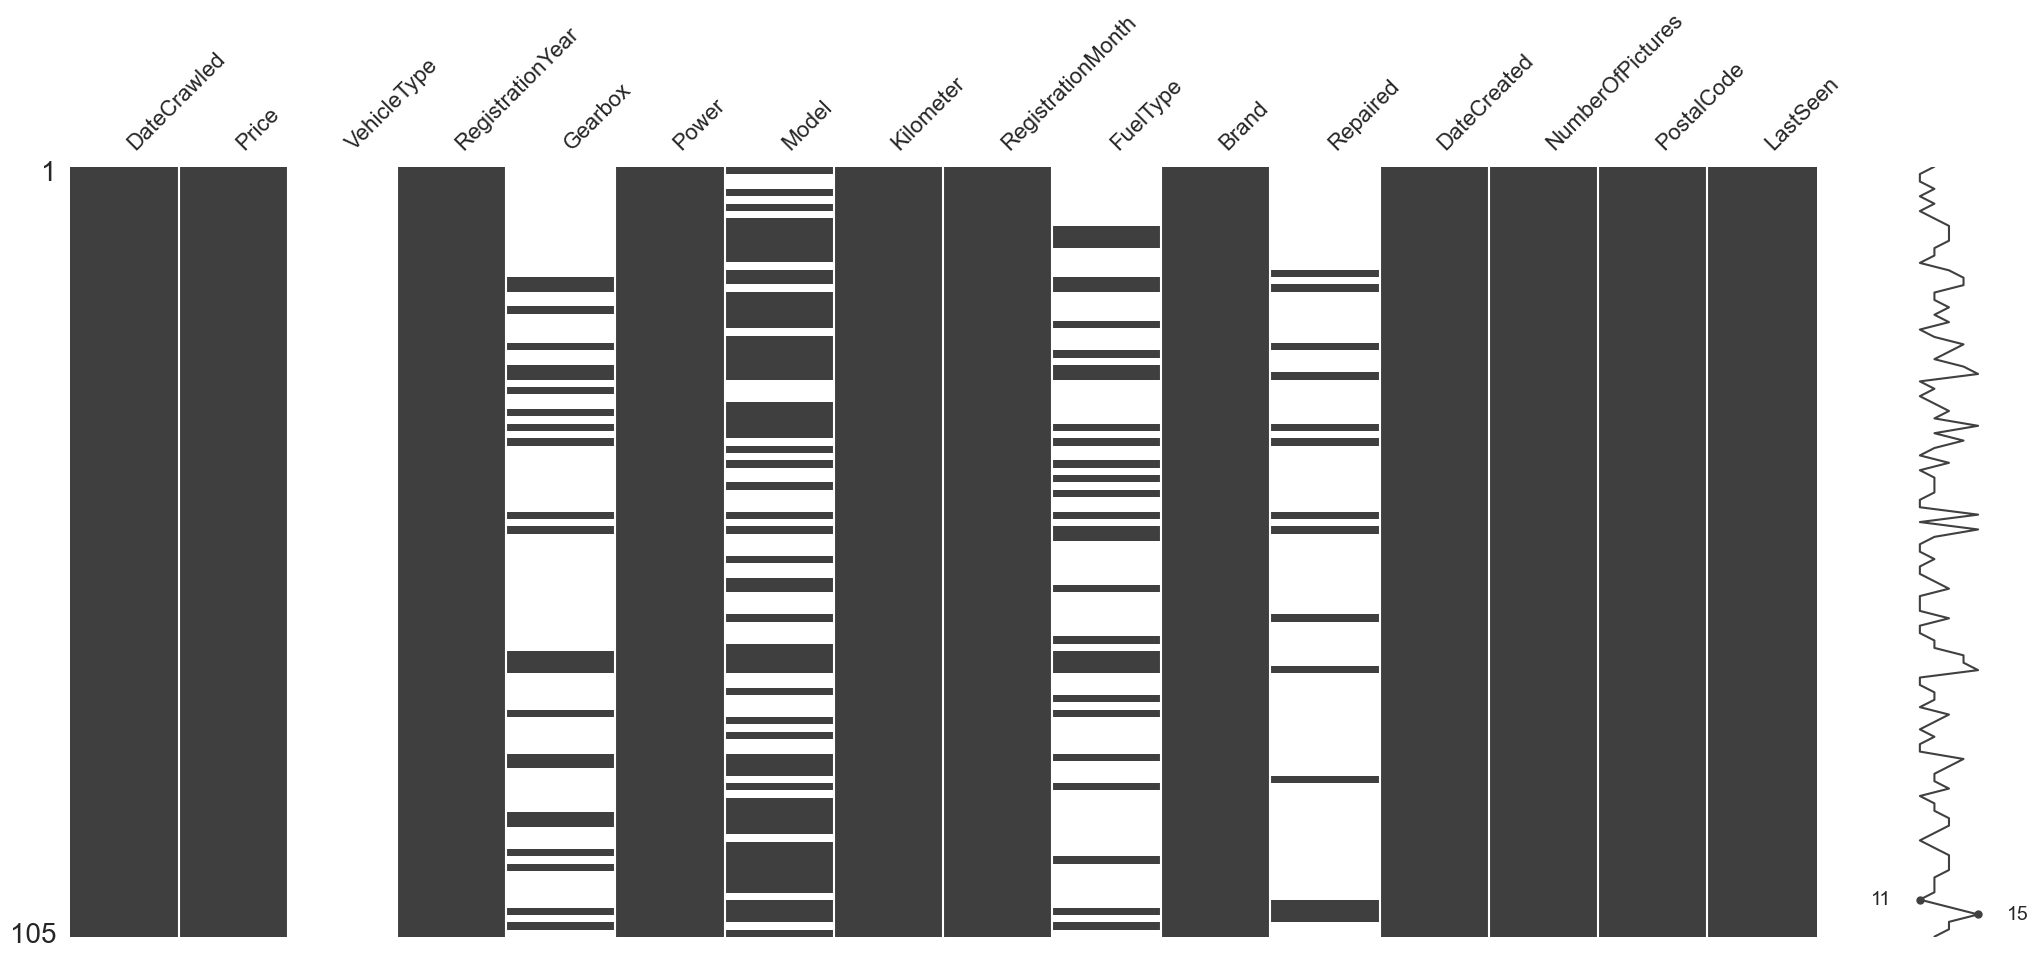

In [41]:
mn.missingno.matrix(df.loc[df.RegistrationYear > 2019])

Как видно, пользователи не удосужился заполнить объявление. Т.к. таких объявлений не много, то мы их безжалостно выбросим

In [78]:
df.drop(df.loc[df.RegistrationYear > 2019].index, inplace=True)
df.describe().T

,count,mean,min,25%,50%,75%,max,std
DateCrawled,354187,2016-03-21 12:57:23.743542016,2016-03-05 14:06:22,2016-03-13 11:52:13.500000,2016-03-21 17:50:51,2016-03-29 14:37:17,2016-04-07 14:36:58,NaN
Price,354187.0,4417.414403,0.0,1050.0,2700.0,6400.0,20000.0,4514.185231
RegistrationYear,354187.0,2002.936085,1000.0,1999.0,2003.0,2008.0,2019.0,13.866662
Power,354187.0,106.496819,0.0,69.0,105.0,141.0,600.0,63.42571
Kilometer,354187.0,128250.86748,5000.0,125000.0,150000.0,150000.0,150000.0,37849.041257
RegistrationMonth,354187.0,5.716006,0.0,3.0,6.0,9.0,12.0,3.725769
DateCreated,354187,2016-03-20 19:11:17.896139520,2014-03-10 00:00:00,2016-03-13 00:00:00,2016-03-21 00:00:00,2016-03-29 00:00:00,2016-04-07 00:00:00,NaN
NumberOfPictures,354187.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PostalCode,354187.0,50510.818703,1067.0,30165.0,49413.0,71083.0,99998.0,25783.82305
LastSeen,354187,2016-03-29 23:50:56.228977920,2016-03-05 14:15:08,2016-03-23 02:50:03,2016-04-03 15:15:52,2016-04-06 10:15:20,2016-04-07 14:58:51,NaN


In [43]:
categorical_cols = ["VehicleType", "Gearbox", "FuelType", "Brand", "Model", "Repaired"]

 Изменим тип на категории и проверим количество пустых

In [79]:
for category in categorical_cols:
    df[category] = df[category].astype("category")


Проверим входные данные на соответствие нормальным

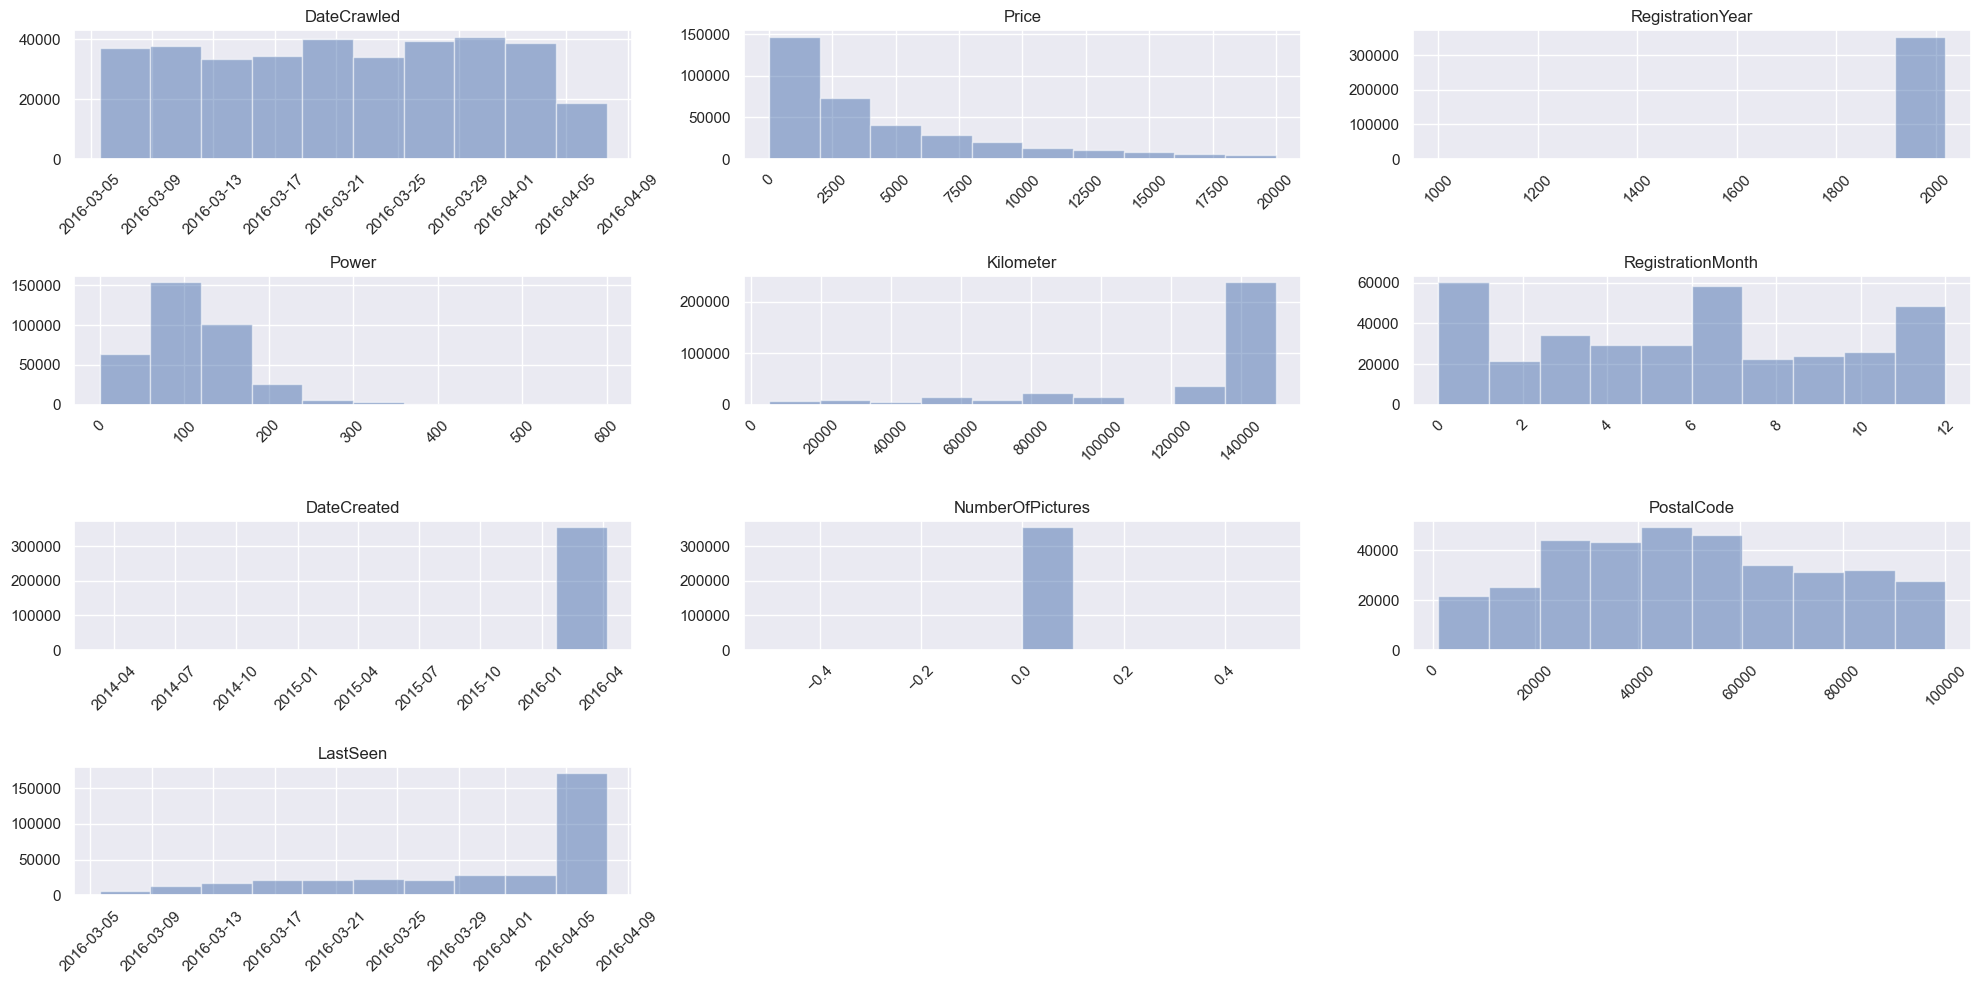

In [45]:
df.hist(alpha=0.5, figsize=(20, 10), xrot=45)
plt.tight_layout()
plt.show()


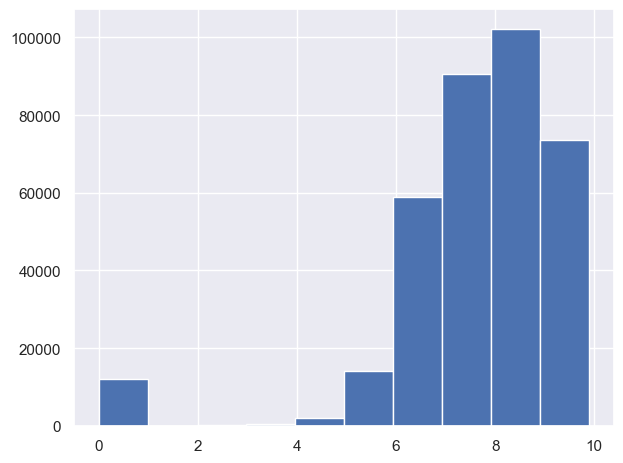

In [46]:
df["price_log"] = np.log1p(df["Price"])
df.price_log.hist()
plt.tight_layout()
plt.show()


Получилось не очень круто. Но, что имеем, то имеем.


In [47]:
df = df.drop(columns=["price_log"]) 

Отбросим строки с незаполненной ценой

In [80]:
df = df.loc[df.Price != 0]

Изменим тип дат на int64


In [81]:
df["DateCrawled"] = df["DateCrawled"].astype("int64")
df["DateCreated"] = df["DateCreated"].astype("int64")
df["LastSeen"] = df["LastSeen"].astype("int64")
df["RegistrationYear"] = df["RegistrationYear"].astype("int64")
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 343441 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   DateCrawled        343441 non-null  int64   
 1   Price              343441 non-null  int64   
 2   VehicleType        309792 non-null  category
 3   RegistrationYear   343441 non-null  int64   
 4   Gearbox            326161 non-null  category
 5   Power              343441 non-null  int64   
 6   Model              325993 non-null  category
 7   Kilometer          343441 non-null  int64   
 8   RegistrationMonth  343441 non-null  int64   
 9   FuelType           314061 non-null  category
 10  Brand              343441 non-null  category
 11  Repaired           277669 non-null  category
 12  DateCreated        343441 non-null  int64   
 13  NumberOfPictures   343441 non-null  int64   
 14  PostalCode         343441 non-null  int64   
 15  LastSeen           343441 non-null  int

Преобразуем категории в числовые значение

In [82]:
def category_to_dict(col: pd.Series):
    map_ = {}
    for count, category in enumerate(col.unique()):
        if pd.isna(np.array([category,])):
            continue
        map_[category] = count

    return map_

In [83]:
categories_map = {}

In [84]:

for category in categorical_cols:
    map_ = category_to_dict(df[category])
    categories_map[category] = map_
    df[category] = df[category].map(map_)

In [14]:
#df.dropna(how="any", inplace=True)

<Axes: >

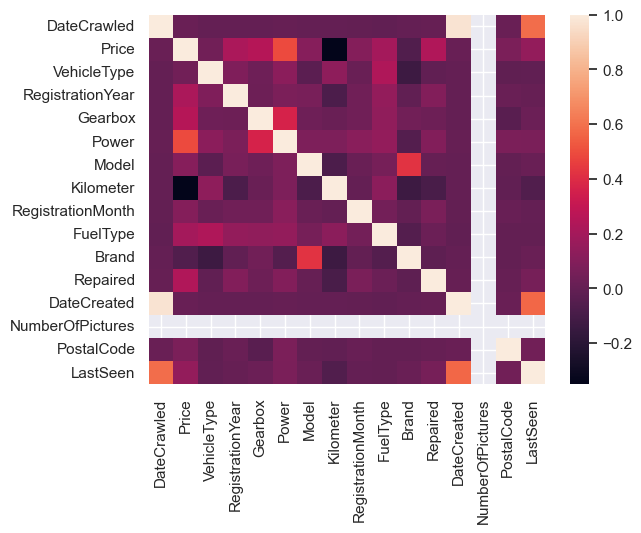

In [53]:
sns.heatmap(df.corr())

Видно, что DateCreated - DateCrawled идут нога в ногу. С ними рядом идет Last Seen. Оставим только DateCrawled
PS Позже выяснилось, что LastSeen важнее

In [85]:
df.drop(columns=["DateCreated", "DateCrawled", "NumberOfPictures"], inplace=True)

In [86]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,343441.0,4.555632e+03,4.515065e+03,1.000000e+00,1.200000e+03,2.890000e+03,6.500000e+03,2.000000e+04
RegistrationYear,343441.0,2.003057e+03,1.290785e+01,1.000000e+03,1.999000e+03,2.003000e+03,2.008000e+03,2.019000e+03
Power,343441.0,1.074884e+02,6.287555e+01,0.000000e+00,6.900000e+01,1.050000e+02,1.430000e+02,6.000000e+02
Kilometer,343441.0,1.283720e+05,3.747200e+04,5.000000e+03,1.250000e+05,1.500000e+05,1.500000e+05,1.500000e+05
RegistrationMonth,343441.0,5.779054e+00,3.697577e+00,0.000000e+00,3.000000e+00,6.000000e+00,9.000000e+00,1.200000e+01
PostalCode,343441.0,5.068540e+04,2.574470e+04,1.067000e+03,3.044900e+04,4.952500e+04,7.122900e+04,9.999800e+04
LastSeen,343441.0,1.459299e+18,7.920752e+14,1.457187e+18,1.458714e+18,1.459702e+18,1.459938e+18,1.460041e+18


FuelType имеет слишком много значений. Проанализируем этот признак.

In [87]:
categories_map["FuelType"]

{'petrol': 0,
 'gasoline': 1,
 'lpg': 3,
 'other': 4,
 'hybrid': 5,
 'cng': 6,
 'electric': 7}

Объедением petrol и gasoline, т.к. это одно и то же

In [88]:
df.FuelType = df.FuelType.replace(to_replace=1, value=0)

In [193]:
categories_map

{'VehicleType': {'coupe': 1,
  'suv': 2,
  'small': 3,
  'sedan': 4,
  'convertible': 5,
  'bus': 6,
  'wagon': 7,
  'other': 8},
 'Gearbox': {'manual': 0, 'auto': 1},
 'FuelType': {'petrol': 0,
  'gasoline': 1,
  'lpg': 3,
  'other': 4,
  'hybrid': 5,
  'cng': 6,
  'electric': 7},
 'Brand': {'volkswagen': 0,
  'audi': 1,
  'jeep': 2,
  'skoda': 3,
  'bmw': 4,
  'peugeot': 5,
  'ford': 6,
  'mazda': 7,
  'nissan': 8,
  'renault': 9,
  'mercedes_benz': 10,
  'opel': 11,
  'seat': 12,
  'citroen': 13,
  'honda': 14,
  'fiat': 15,
  'mini': 16,
  'smart': 17,
  'hyundai': 18,
  'sonstige_autos': 19,
  'alfa_romeo': 20,
  'subaru': 21,
  'volvo': 22,
  'mitsubishi': 23,
  'kia': 24,
  'suzuki': 25,
  'lancia': 26,
  'toyota': 27,
  'chevrolet': 28,
  'dacia': 29,
  'daihatsu': 30,
  'trabant': 31,
  'saab': 32,
  'chrysler': 33,
  'jaguar': 34,
  'daewoo': 35,
  'porsche': 36,
  'rover': 37,
  'land_rover': 38,
  'lada': 39},
 'Model': {'golf': 0,
  'grand': 2,
  'fabia': 3,
  '3er': 4,
  

Поработаем с отсутствующими данными

In [89]:
df.isna().sum()

Price                    0
VehicleType          33649
RegistrationYear         0
Gearbox              17280
Power                    0
Model                17448
Kilometer                0
RegistrationMonth        0
FuelType             29380
Brand                    0
Repaired             65772
PostalCode               0
LastSeen                 0
dtype: int64

Пойдем вабанк.
VehicleType имеет заметельную категорю - other. Поставим ее вместо nan
FuelType - пусть будет 0 (Petrol)
Repaired - очень важный признак. Неизвестное состояние пусть примет значение 3
Model меняем на other
GearBox - сложный вопрос...

Если будет необходимость, то их заменим на соответствующие из других объявлений

PS Не будем менять Repaired, т.к. это значительно снижает зависимость от этого признака


In [90]:

df['VehicleType'] = df['VehicleType'].fillna(categories_map["VehicleType"]["other"])
df['FuelType'] = df['FuelType'].fillna(categories_map["FuelType"]["petrol"])
# df['Repaired'] = df['Repaired'].cat.add_categories([3]).fillna(3)
df['Model'] = df['Model'].fillna(categories_map["Model"]["other"])
df['Gearbox'] = df['Gearbox'].cat.add_categories([3]).fillna(3)

In [91]:
df.isna().sum()

Price                    0
VehicleType              0
RegistrationYear         0
Gearbox                  0
Power                    0
Model                    0
Kilometer                0
RegistrationMonth        0
FuelType                 0
Brand                    0
Repaired             65772
PostalCode               0
LastSeen                 0
dtype: int64

### 3.4 Рассмотрим признаки на основе оценки их значимости для составления математической модели:
    (Чем выше число, тем сильнее связь между признаком и целевой переменной)

In [92]:
X = df.drop('Price', axis=1)
y = df['Price']

num_features_to_select = 3
selector = SelectKBest(score_func=f_classif, k=num_features_to_select)
selector.fit(X, y)

all_feature_scores = selector.scores_
feature_names = X.columns
for feature, score in zip(feature_names, all_feature_scores):
    print(f"Признак: {feature}, Оценка: {score}")

Признак: VehicleType, Оценка: 1.7788952563258171
Признак: RegistrationYear, Оценка: 6.644675692956067
Признак: Gearbox, Оценка: 3.566833010235216
Признак: Power, Оценка: 34.396327661533114
Признак: Model, Оценка: 2.6327023989011265
Признак: Kilometer, Оценка: 16.48053609795587
Признак: RegistrationMonth, Оценка: 3.780829728574247
Признак: FuelType, Оценка: 1.0274962398086667
Признак: Brand, Оценка: 1.87637389886185
Признак: Repaired, Оценка: 7.1367536344080325
Признак: PostalCode, Оценка: 1.8489861637026863
Признак: LastSeen, Оценка: 3.5343097825373686


Попробуем отбросить DateCrawled, Repaired, PostalCode, Brand, VehicleType, FuelType.
(Для сравнения, без фильтрации, простым удалением NaN удалось добиться RMSE 1880)

PS. Данный шаг ускорил обучение почти в два раза. Но RMSE увеличился до 2105
PS2 ПоселВ одной из итераций обработки Repaired nan были заменены на третью неизвестную категорию и эту сущесттвенно снизило зависимость от данного признака

In [ ]:
df.drop(columns=["DateCrawled", "PostalCode", "DateCreated",
                 ], inplace=True)

array([[<Axes: title={'center': 'Price'}>,
        <Axes: title={'center': 'RegistrationYear'}>,
        <Axes: title={'center': 'Power'}>],
       [<Axes: title={'center': 'Kilometer'}>,
        <Axes: title={'center': 'RegistrationMonth'}>,
        <Axes: title={'center': 'PostalCode'}>],
       [<Axes: title={'center': 'LastSeen'}>, <Axes: >, <Axes: >]],
      dtype=object)

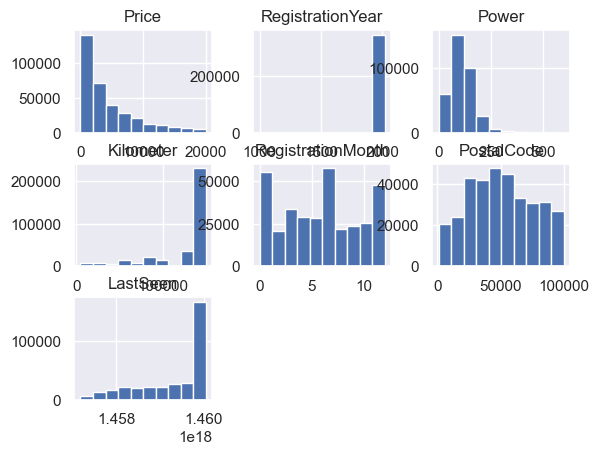

In [94]:
df.hist()

Ну как бы ОК

Разбивка на выборки и разбивка подготовка гиперпараметров

In [95]:
y = df["Price"]
X = df.drop(columns=["Price"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=RANDOM_SEED)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.1, random_state=13)

params = {'n_estimators': 500,#00,
          'max_depth': 5,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'squared_error'}

Через cross vlaidation


In [97]:
X_cv = pd.concat([X_train, X_valid])
y_cv = pd.concat([y_train, y_valid])

In [98]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X, y)

import pickle
with open("gridscvRFG", "wb") as f:
    pickle.dump(grid_search, f)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


In [ ]:


from sklearn.model_selection import GridSearchCV

best_result = {
    'model': None,
    'RMSE': 0,
    'estimators': 0,
    'depth': 0,
}

param_grid = {
    'n_estimators': range(1, 33),
    'max_depth': range(2, 10),
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=RANDOM_SEED), param_grid, cv=5, verbose=True)
grid_search.fit(X_balanced_mod_wo_valid, y_balanced_mod_wo_valid)

for params, mean_score, _ in zip(grid_search.cv_results_['params'], grid_search.cv_results_['mean_test_score'], grid_search.cv_results_['std_test_score']):
    print(f"Parameters: {params}, Mean accuracy: {mean_score}, Std: {_.round(4)}")

best_result['model'] = grid_search.best_estimator_
best_result['accuracy'] = grid_search.best_score_
best_result['estimators'] = grid_search.best_params_['n_estimators']
best_result['depth'] = grid_search.best_params_['max_depth']

print("Best Model:", best_result['model'])
print("Best Accuracy:", best_result['accuracy'])
print("Best Parameters:", best_result['estimators'], "estimators,", best_result['depth'], "depth")


In [334]:
import time
from IPython.core.magics.execution import _format_time
from IPython.display import display as d
from IPython.display import Audio
from IPython.core.display import HTML
import numpy as np
import logging as log

def alert():
    """ makes sound on client using javascript (works with remote server) """      
    framerate = 44100
    duration= 5
    freq=300
    t = np.linspace(0,duration,framerate*duration)
    data = np.sin(2*np.pi*freq*t)
    d(Audio(data,rate=framerate, autoplay=True))
    

Обучение бустинговой модели

In [337]:
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)


GradientBoostingRegressor(learning_rate=0.01, max_depth=5, min_samples_split=5,
                          n_estimators=500)

In [338]:
rmse_v = root_mean_squared_error(y_valid, reg.predict(X_valid))
rmse_t = root_mean_squared_error(y_test, reg.predict(X_test))
print("The mean squared error (RMSE) on valid set: {:.4f}".format(rmse_v))
print("The mean squared error (RMSE) on test set: {:.4f}".format(rmse_t))

The mean squared error (RMSE) on valid set: 1915.2055
The mean squared error (RMSE) on test set: 1928.0794


Теперь проверим модель на не фильтрованных данных, пересоздав фрейм

<Axes: >

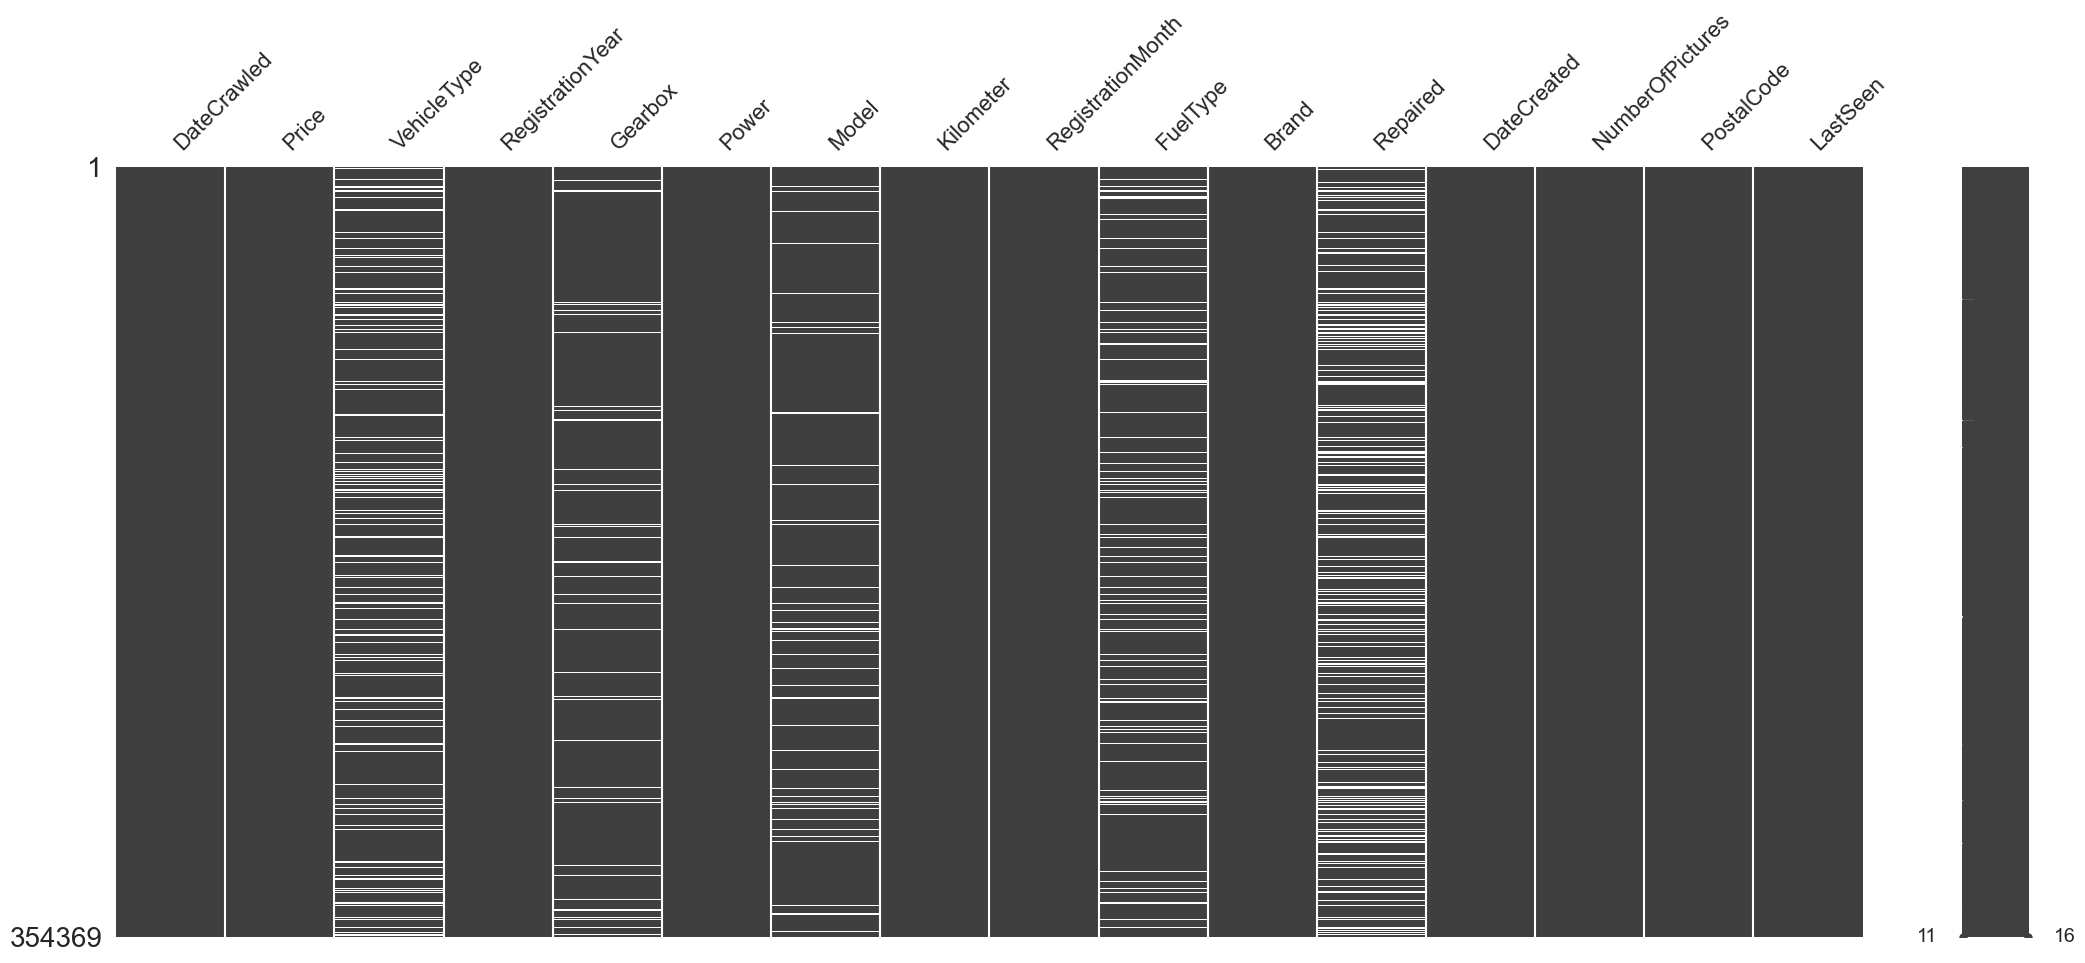

In [172]:
mn.missingno.matrix(df)

In [173]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns="Price"), df.Price, test_size=0.1, random_state=RANDOM_SEED)

In [174]:
mse = root_mean_squared_error(y_train, reg.predict(X_train))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

c:\Users\fahru\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arrays\base.py:568: RuntimeWarning: invalid value encountered in cast
  result = np.asarray(self, dtype=dtype)


The mean squared error (MSE) on test set: 1973.5764


In [44]:
import pickle
with open("regression_model.bin", "wb") as f:
    pickle.dump(reg, f)

Визуализация результата работы модели

In [171]:
df

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,1458820337000000000,480,NaN,1993,0,0,0,150000,0,0,0,NaN,1458777600000000000,0,70435,1459999017000000000
1,1458817125000000000,18300,1,2011,0,190,NaN,125000,5,1,1,1,1458777600000000000,0,66954,1459993610000000000
2,1457959941000000000,9800,2,2004,1,163,2,125000,8,1,2,NaN,1457913600000000000,0,90480,1459860466000000000
3,1458233644000000000,1500,3,2001,0,75,0,150000,6,0,0,2,1458172800000000000,0,91074,1458236417000000000
4,1459445120000000000,3600,3,2008,0,69,3,90000,7,1,3,2,1459382400000000000,0,60437,1459937841000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,1458553858000000000,0,NaN,2005,0,0,78,150000,7,0,23,1,1458518400000000000,0,2694,1458556969000000000
354365,1457977707000000000,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,19,NaN,1457913600000000000,0,39576,1459903612000000000
354366,1457207781000000000,1199,5,2000,1,101,29,125000,3,0,17,2,1457136000000000000,0,26135,1457720232000000000
354367,1458413832000000000,9200,6,1996,0,102,21,150000,3,1,0,2,1458345600000000000,0,87439,1460013326000000000


Ниже не используется и не работает

In [ ]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = reg.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, reg.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()

In [ ]:
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(df.feature_names)[sorted_idx])
plt.title('Feature Importance (MDI)')

result = permutation_importance(reg, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(df.feature_names)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

Логистическая регрессия

In [14]:
LR = LogisticRegression(random_state = RANDOM_SEED, max_iter= 10, solver = 'lbfgs' )
LR.fit(X_train, y_train)
prediction_valid_LR = LR.predict(X_valid)

In [ ]:
mse = mean_squared_error(y_valid, prediction_valid_LR)
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

Выводы.  Потратил 6 часов на заполнение пропусков - улучшений нет
